# Tweet Sentiment Classifier

---
embed-resources: true
---

## Introduction

In this report our goal is develop a model that can accurately predict the sentiment of tweets (positive or negative) directed at U.S airlines. Our model will classify words from the tweets to make predictions of satisfication or frustation with the airline. From this we can help airlines improve their responses to public feedback. In turn customer service teams and prioritize negative tweets for faster support which will boost brand reputation and improve customer satisfication.


## Methods

In [1]:
# imports

# basics
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import dump


#text processing
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline

# probability
from scipy.stats import norm
from scipy.stats import multivariate_normal

# machine learning
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV


The data contains tweets about airlines, each observation is one tweet. The variables considered are:

#### Response

`sentiment`
- **`[object]`** the sentiment of the tweet. One of negative, neutral, or positive.

#### Features

`text`
- **`[object]`** the full text of the tweet.

#### Additional Variables

`airline`
- **`[object]`** the airline the tweet was “sent” to.


### Data

In [2]:
# load data

tweets_train = pd.read_parquet(
    "https://cs307.org/lab/data/tweets-train.parquet",
)
tweets_test = pd.read_parquet(
    "https://cs307.org/lab/data/tweets-test.parquet",
)

# create X and y for train data
X_train = tweets_train["text"]
y_train = tweets_train["sentiment"]

# create X and y for test data
X_test = tweets_test["text"]
y_test = tweets_test["sentiment"]

In [3]:
X_train

8318     @JetBlue Then en route to the airport the rebo...
3763     @united now you've lost my bags too.  At least...
9487     @USAirways Hi, can you attach my AA FF# 94LXA6...
2591     @United, will you fill it? Yes they will. Than...
12887    @AmericanAir thanks! I hope we get movies. Tv'...
                               ...                        
3416     @united Can i get a refund? I would like to bo...
279      @VirginAmerica what is your policy on flying a...
1814     @united I'm not sure how you can help. Your fl...
29       @VirginAmerica LAX to EWR - Middle seat on a r...
1130     @united Hopefully my baggage fees will be waiv...
Name: text, Length: 8235, dtype: object

In [4]:
# summary statistics
pd.DataFrame({
    'count': tweets_train['airline'].value_counts(),
    'proportion': tweets_train['airline'].value_counts(normalize=True)
})

,count,proportion
airline,,
United,2166,0.263024
US Airways,1664,0.202064
American,1551,0.188342
Southwest,1347,0.163570
Delta,1239,0.150455
Virgin America,268,0.032544


We see that 6 airlines are considered.

In [5]:
word_counter = CountVectorizer()
word_counts = word_counter.fit_transform(X_train)

cancelled_idx = np.where(word_counter.get_feature_names_out() == "cancelled")
cancelled_count = np.sum(word_counts.todense()[:, cancelled_idx])
print('The Word cancelled Appears:', cancelled_count)

please_idx = np.where(word_counter.get_feature_names_out() == "please")
please_count = np.sum(word_counts.todense()[:, please_idx])

print('The Word please Appears:', please_count)

thanks_idx = np.where(word_counter.get_feature_names_out() == "thanks")
thanks_count = np.sum(word_counts.todense()[:, thanks_idx])
print('The Word thanks Appears:', thanks_count)









The Word cancelled Appears: 595
The Word please Appears: 325
The Word thanks Appears: 587


In [6]:
pd.DataFrame(
    word_counts.todense(),
    columns=sorted(list(word_counter.vocabulary_.keys())),
)

,00,000,000114,000ft,0016,00a,00am,00p,00pm,0162389030167,...,zones,zoom,zrh,zrh_airport,zsdgzydnde,zsuztnaijq,ztrdwv0n4l,zurich,zv2pt6trk9,zv6cfpohl5
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8230,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8231,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8232,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8233,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


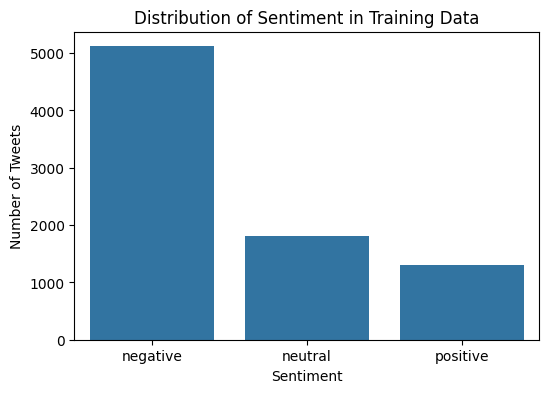

In [7]:
# exploratory visualization
plt.figure(figsize=(6, 4))
sns.countplot(data=tweets_train, x="sentiment", order=["negative", "neutral", "positive"])
plt.title("Distribution of Sentiment in Training Data")
plt.xlabel("Sentiment")
plt.ylabel("Number of Tweets")
plt.show()

The data is not balanced with more tweets having negative sentiment than positive or neutral.

### Models

In [8]:
# process data for ML
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier


pipeline = make_pipeline(
    TfidfVectorizer(),
    #GaussianNB(),
    LogisticRegression(),
    #RandomForestClassifier()
)

###stop words???

In [9]:
# train models
# 'gaussiannb__var_smoothing': [1e-9, 1e-8, 1e-7],

param_grid = {
    'tfidfvectorizer__max_df': [0.8, 0.95],
    'tfidfvectorizer__ngram_range': [(1,1), (1,2)],
    'tfidfvectorizer__min_df': [3, 5],
    'tfidfvectorizer__stop_words': [None, 'english'],
    'logisticregression__solver': ['liblinear', 'saga'],

    
    'logisticregression__C': [0.01, 0.1, 1, 10],
    'logisticregression__max_iter': [100, 200],
    'logisticregression__penalty': ['l2'],
    'logisticregression__class_weight': [None, 'balanced'],
    


}




mod = GridSearchCV(pipeline, param_grid, cv = 5, scoring = 'accuracy', n_jobs = -1)

mod.fit(X_train, y_train)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                                       ('logisticregression',
                                        LogisticRegression())]),
             n_jobs=-1,
             param_grid={'logisticregression__C': [0.01, 0.1, 1, 10],
                         'logisticregression__class_weight': [None, 'balanced'],
                         'logisticregression__max_iter': [100, 200],
                         'logisticregression__penalty': ['l2'],
                         'logisticregression__solver': ['liblinear', 'saga'],
                         'tfidfvectorizer__max_df': [0.8, 0.95],
                         'tfidfvectorizer__min_df': [3, 5],
                         'tfidfvectorizer__ngram_range': [(1, 1), (1, 2)],
                         'tfidfvectorizer__stop_words': [None, 'english']},
             scoring='accuracy')

## Results

In [10]:
# report model metrics

y_pred = mod.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"Test accuracy: {acc}")

Test accuracy: 0.8021857923497268


~80% accuracy in classifying sentiment on test data.

In [11]:

pred_proba = mod.predict_proba(X_test)
pred_proba

array([[0.31600856, 0.66018889, 0.02380255],
       [0.5940951 , 0.00765946, 0.39824544],
       [0.62086884, 0.11220055, 0.26693061],
       ...,
       [0.87865829, 0.00345772, 0.11788399],
       [0.97567294, 0.01757038, 0.00675668],
       [0.20599887, 0.71684396, 0.07715717]], shape=(2745, 3))

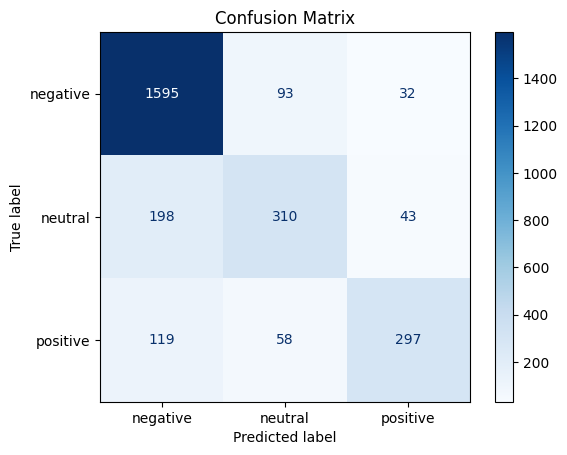

In [12]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred, labels=["negative", "neutral", "positive"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["negative", "neutral", "positive"])

disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

This shows our model is able to predict tweet sentiment with strong performance, especially for negative tweets, where it correctly identified 1,595 cases. This is important, as negative tweets are the most urgent for customer service to address. However, the model struggles more with neutral and positive tweets, often mixing them up. It is also important to note that the neutral class shows the most confusion, which could be due to the ambiguous nature of neutral tweets.

In [14]:
# serialize model


dump(mod, 'tweets.joblib')

['tweets.joblib']

## Discussion

Due to the model's accuracy of approximately 80%, which is strong given the nuance and of social media posts `I would reccomend to use this model.` Especially considereding that our model is more effective at identifying negative tweets, correctly classifying 1595 of the 1720 cases. This aligns with our goal of the model, to recognize negative tweets so the customer service can target those and respond to them more efficient to increase customer satisifcation.

I would not reccomend using the model to automate responses, but to specifically recgonzie positive and negative sentiment posts. These posts can be flagged, and a customer service team can response to the negative tweets to increase customer satisfication. This model would be more effective than no model, and there a low downside to not using the model -- you would not see all of the posts with negative sentiment but the tradeoff of recognizing them quicker and being able to respond faster is worth this trade.

Future work in this area can include expanding the data set for greater class represetation and testing alterative models such as Support Vector Machine models or models that transform the data. We could also try to score the amount of postive and negative sentiment, not just as positive or negative but with a score such as +3 happy or -2 negative sentiment.